## Two regularisation methods

In [1]:
# recon_pair.py  ─── run “python recon_pair.py”
import torch, deepinv as dinv
from pathlib import Path
import matplotlib.pyplot as plt

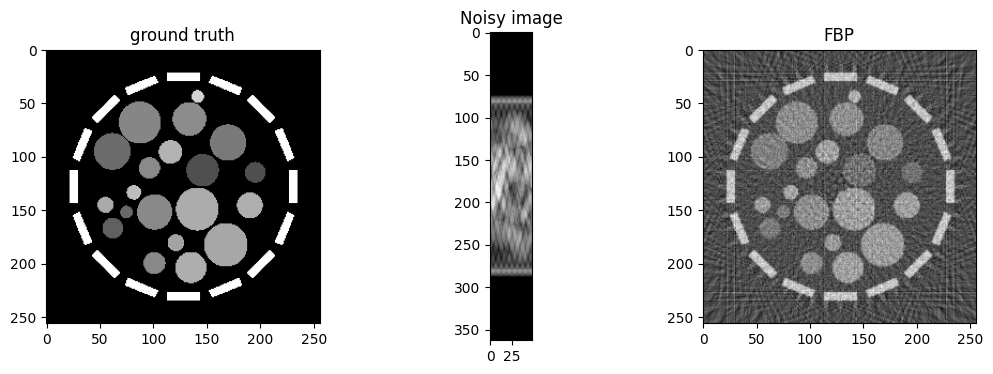

fbp tensor([[[[ 0.1247,  0.1757,  0.2018,  ...,  0.0708, -0.0090, -0.0076],
          [ 0.1300,  0.1211,  0.2093,  ...,  0.0180, -0.1253,  0.0708],
          [ 0.1124,  0.1382,  0.2056,  ..., -0.0851,  0.0440,  0.1482],
          ...,
          [ 0.1459, -0.1291, -0.0356,  ..., -0.0112, -0.1778, -0.2444],
          [ 0.0142,  0.0450,  0.2067,  ...,  0.0822,  0.0899, -0.0158],
          [ 0.0858,  0.0851,  0.0290,  ..., -0.0407,  0.0310, -0.0782]]]],
       device='cuda:0')
x_gt: nan? False inf? False all zero? False
y:    nan? False inf? False all zero? False


In [16]:
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import numpy as np


# ── parameters ───────────────────────────────
IMG_SZ, ANGLES, GAIN      = 256, 50, 1/40          # physics
DEVICE                    = "cuda" if torch.cuda.is_available() else "cpu"

# Load the shepp logan phantom
# Load and convert to torch tensor with correct size and device
# phantom = shepp_logan_phantom()
# phantom_resized = resize(phantom, (IMG_SZ, IMG_SZ), mode='reflect', anti_aliasing=True)

index = 12
# load created phantom
phantoms = np.load("data/phantoms.npy", allow_pickle=True)
IMG_SZ = phantoms[index].shape[0]
phantom_resized = phantoms[index]

x_gt = torch.from_numpy(phantom_resized.astype(np.float32)).to(DEVICE)
x_gt = x_gt.unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions

# ── 0. toy phantom  +  Poisson measurements ─────────────────────────
# x_gt  = dinv.utils.demo.load_image("shepp_logan", img_size=IMG_SZ).to(DEVICE)
physics = dinv.physics.Tomography(
    img_width=IMG_SZ, angles=ANGLES, device=DEVICE,
    noise_model=dinv.physics.PoissonNoise(gain=GAIN), verbose=False)

y = physics(x_gt)


# Try a simple reconstruction FBP
# ── 1. FBP reconstruction ───────────────────────────────
fbp = physics.A_dagger(y)

# ── plot the ground truth and the corrupted image.
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")

plt.subplot(132)
plt.imshow(y.cpu()[0,0,:,:], cmap = 'gray')
plt.title("Noisy image")

plt.subplot(133)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")

plt.show()

print("fbp", fbp)

# Diagnostic: Check for NaNs, Infs, and all-zeros in x_gt and y
print("x_gt: nan?", torch.isnan(x_gt).any().item(), "inf?", torch.isinf(x_gt).any().item(), "all zero?", torch.all(x_gt == 0).item())
print("y:    nan?", torch.isnan(y).any().item(),    "inf?", torch.isinf(y).any().item(),    "all zero?", torch.all(y == 0).item())

100.0
Iteration 298, current converge crit. = 9.69E-06, objective = 1.00E-05 
psnr
cost
residual
torch.Size([1, 1, 256, 256])
X_a: tensor([[[[-0.0154, -0.0179,  0.0230,  ..., -0.0138,  0.0253,  0.0374],
          [ 0.0306, -0.0361, -0.0064,  ...,  0.0088,  0.0294,  0.0150],
          [ 0.0517, -0.0043,  0.0078,  ...,  0.0133,  0.0220,  0.0204],
          ...,
          [ 0.0221, -0.0037,  0.0488,  ...,  0.0214, -0.0109, -0.0490],
          [ 0.0099,  0.0487,  0.0318,  ...,  0.0163,  0.0604, -0.0050],
          [ 0.0329,  0.0246, -0.0140,  ...,  0.0079,  0.0435,  0.0564]]]],
       device='cuda:0')
gt: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


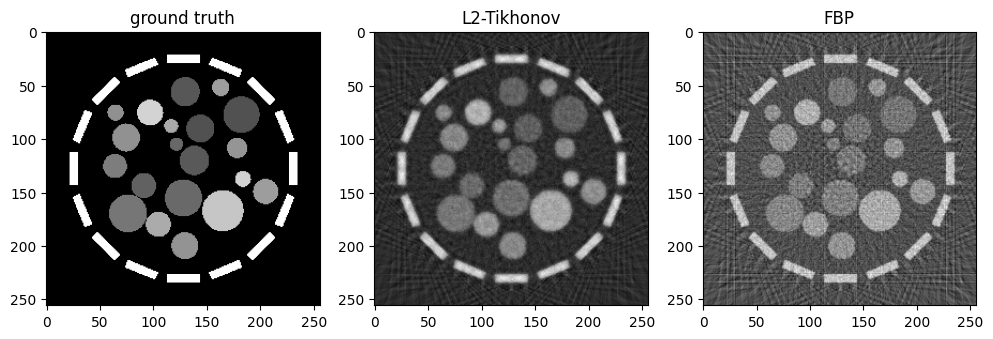

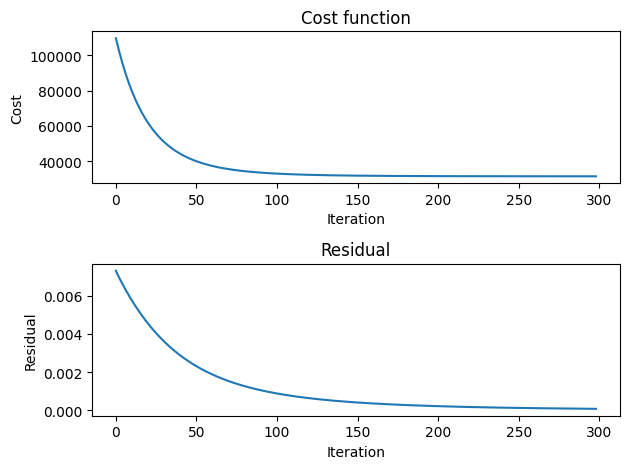

In [8]:
# ── 1A. L2-Tikhonov  (PGD) ──────────────────────────────────────────
from deepinv.optim import optim_builder
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior         import Tikhonov

# prior_A = Tikhonov()
prior = Tikhonov()

# Select the data fidelity term
data_fidelity = L2()
print(1e2)
# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": 0.0001, "lambda": 1e1}

# Logging parameters
verbose = True

# Parameters of the algorithm to solve the inverse problem
early_stop = True  # Stop algorithm when convergence criteria is reached
crit_conv = "cost"  # Convergence is reached when the difference of cost function between consecutive iterates is
# smaller than thres_conv
thres_conv = 1e-5 # was 1e-5
backtracking = False  # use backtraking to automatically adjust the stepsize
max_iter = 1000  # Maximum number of iterations


model = optim_builder(
    iteration="GD",
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=early_stop,
    max_iter=max_iter,
    crit_conv=crit_conv,
    thres_conv=thres_conv,
    backtracking=backtracking,
    verbose=verbose,
    custom_init=lambda y, physics: {
        "est": (physics.A_dagger(y), physics.A_dagger(y))
    }
)


# x_A = model(y, physics,x_gt = x_gt, compute_metric = True)
x_A, metrics = model(
    y, physics, x_gt=x_gt, compute_metrics=True
)  # reconstruction with PGD algorithm

for k in metrics:      # or: for k in my_dict.keys()
    print(k)
print(x_A.shape)
print("X_a:",x_A)

print("gt:" ,x_gt)


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(132)
plt.imshow(x_A.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.subplot(133)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(metrics['cost'][0])
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(212)
plt.plot(metrics['residual'][0])
plt.title("Residual")
plt.xlabel("Iteration") 
plt.ylabel("Residual")


plt.tight_layout()
plt.show()

## just gradient descent

grad prior tensor(1.5059, device='cuda:0')
grad l2 tensor(126.0736, device='cuda:0')
75489.8046875
grad prior tensor(1.5040, device='cuda:0')
grad l2 tensor(122.2353, device='cuda:0')
72098.6875
grad prior tensor(1.5021, device='cuda:0')
grad l2 tensor(119.0882, device='cuda:0')
68881.671875
grad prior tensor(1.5002, device='cuda:0')
grad l2 tensor(115.8792, device='cuda:0')
65829.1484375
grad prior tensor(1.4983, device='cuda:0')
grad l2 tensor(112.7914, device='cuda:0')
62932.10546875
grad prior tensor(1.4964, device='cuda:0')
grad l2 tensor(109.7825, device='cuda:0')
60182.0625
grad prior tensor(1.4945, device='cuda:0')
grad l2 tensor(106.8611, device='cuda:0')
57571.03515625
grad prior tensor(1.4926, device='cuda:0')
grad l2 tensor(104.0228, device='cuda:0')
55091.49609375
grad prior tensor(1.4908, device='cuda:0')
grad l2 tensor(101.2660, device='cuda:0')
52736.34375
grad prior tensor(1.4889, device='cuda:0')
grad l2 tensor(98.5882, device='cuda:0')
50498.89453125
grad prior tenso

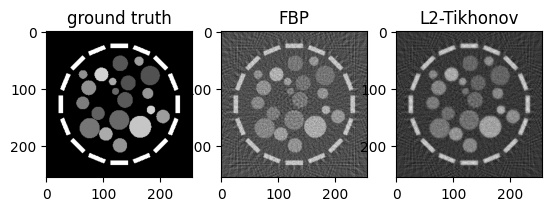

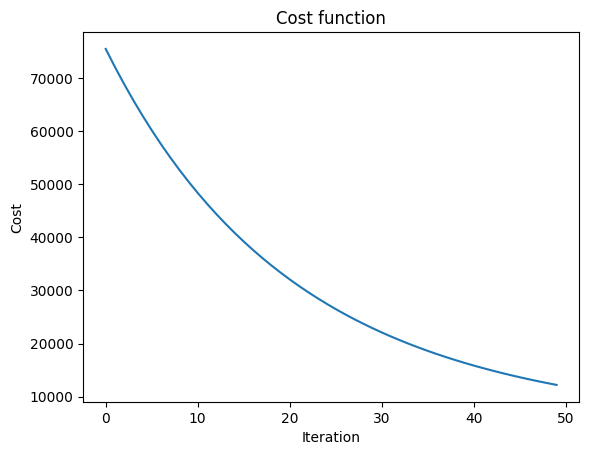

In [6]:
stepsize = 0.0001
max_iter = 50
x_k  = fbp.clone()  # Initialize x_k with the FBP reconstruction
lambd = 1  # Regularization parameter
costs = []
for it in range(max_iter):
    # print(data_fidelity.grad(x_k, y, physics))
    print("grad prior",torch.max(prior.grad(x_k)))
    print("grad l2", torch.max(data_fidelity.grad(x_k, y, physics)))
    x_k = x_k - stepsize*data_fidelity.grad(x_k, y, physics) - stepsize * prior.grad(x_k) # Gradient step
    # print(prior.grad(u))
    # x_k = prior.prox(u, gamma=lambd*stepsize)  # Proximal step
    cost = data_fidelity(x_k, y, physics) + lambd*prior(x_k)  # Compute the cost
    print(cost.item())
    costs.append(cost.item())
plt.figure()
plt.subplot(131)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(132)
plt.imshow(fbp.cpu()[0,0,:,:], cmap = 'gray')
plt.title("FBP")
plt.subplot(133)
plt.imshow(x_k.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.show()

plt.figure()
plt.plot(costs)
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()


## let us try the poisson likelihood

and figure out what parameters work to get okay results

note it is fun to switch between poisson and L2 to see the difference

Iteration 226, current converge crit. = 7.33E-06, objective = 1.00E-05 
tensor([[[[ 1.0766e-02,  1.1223e-02,  8.2365e-03,  ...,  1.5010e-04,
           -6.8216e-04, -2.0763e-03],
          [ 1.0205e-02,  8.0828e-03,  8.3511e-03,  ..., -3.4835e-04,
           -5.1316e-04, -2.7273e-03],
          [ 7.2004e-03,  7.5193e-03,  7.7612e-03,  ..., -1.0162e-05,
           -3.2272e-03, -4.0977e-04],
          ...,
          [-6.6940e-03, -6.1812e-03, -7.0232e-03,  ..., -9.4142e-03,
           -1.2819e-02, -1.0759e-02],
          [-4.9923e-03, -5.2147e-03, -1.9983e-03,  ..., -1.0789e-02,
           -8.3454e-03, -9.4390e-03],
          [-4.1925e-03, -4.8032e-03, -4.8044e-03,  ..., -9.0284e-03,
           -1.1991e-02, -1.0303e-02]]]], device='cuda:0')
{'psnr': [[16.14250946044922, 16.30653953552246, 16.468538284301758, 16.628442764282227, 16.78619956970215, 16.941753387451172, 17.09503936767578, 17.24601173400879, 17.394615173339844, 17.540800094604492, 17.68451499938965, 17.825712203979492, 17.964

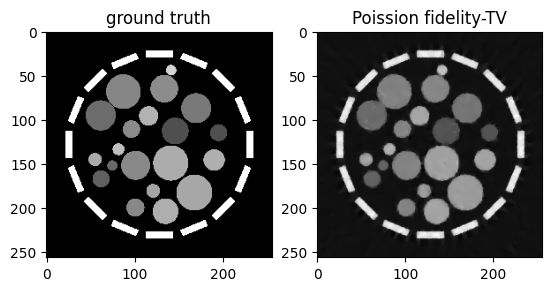

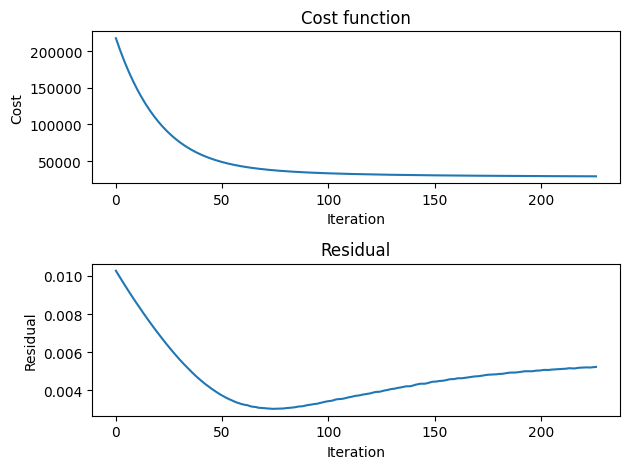

In [ ]:
from deepinv.optim.data_fidelity import PoissonLikelihood
from deepinv.optim.prior         import TVPrior, Tikhonov
from deepinv.optim               import optim_builder

GAIN        = 1/40          # same as you used to corrupt y
λ_tv        = 1e1         # tweak ↑ for sharper / ↓ for smoother
max_iter_B  = 500

prior_B   = TVPrior()
# prior_B = Tikhonov()
fidelityB = PoissonLikelihood(gain=GAIN,bkg=0.01, denormalize= True)
# fidelityB = L2()
SCALING = 1
model_B = optim_builder(
    iteration="GD",
    prior=prior_B,
    data_fidelity=fidelityB,
    params_algo={"stepsize": 0.0001, "lambda": λ_tv},   # PD3O default is usually fine
    max_iter=max_iter_B,
    early_stop=True,
    crit_conv="cost",
    thres_conv=1e-5,
    verbose=True,
    # custom_init=lambda y, physics: {
    #     "est": (physics.A_adjoint(y) * SCALING, physics.A_adjoint(y) * SCALING)
    # }
    custom_init=lambda y, physics: {
        "est": (physics.A_dagger(y), physics.A_dagger(y))
    }
    # custom_init = physics.A_dagger(y)
)

x_B, metrics = model_B(y, physics, x_gt=x_gt, compute_metrics=True)
print(x_B)
print(metrics)

plt.figure()
plt.subplot(121)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(122)
plt.imshow(x_B.cpu()[0,0,:,:], cmap = 'gray')
plt.title("Poission fidelity-TV")
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(metrics['cost'][0])
plt.title("Cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(212)
plt.plot(metrics['residual'][0])
plt.title("Residual")
plt.xlabel("Iteration") 
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [52]:
from deepinv.optim import Prior
# Create a custom prior which inherits from the base Prior class.
class L2Prior(Prior):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def fn(self, x, args, **kwargs):
        return 0.5 * torch.norm(x.view(x.shape[0], -1), p=2, dim=-1) ** 2


# Specify the custom prior
prior = Tikhonov()

# Select the data fidelity term
data_fidelity = L2()

# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": 1, "lambda": 0.1}

# Logging parameters
verbose = True

# Parameters of the algorithm to solve the inverse problem
early_stop = True  # Stop algorithm when convergence criteria is reached
crit_conv = "cost"  # Convergence is reached when the difference of cost function between consecutive iterates is
# smaller than thres_conv
thres_conv = 1e-5
backtracking = False  # use backtraking to automatically adjust the stepsize
max_iter = 500  # Maximum number of iterations

# Instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="ADMM",
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=early_stop,
    max_iter=max_iter,
    crit_conv=crit_conv,
    thres_conv=thres_conv,
    backtracking=backtracking,
    verbose=verbose,
)

Iteration 51, current converge crit. = 7.62E-06, objective = 1.00E-05 
torch.Size([1, 1, 128, 128])
X_a: tensor([[[[-0.0092,  0.0111,  0.0015,  ...,  0.0018,  0.0084, -0.0079],
          [ 0.0005, -0.0093,  0.0253,  ...,  0.0226, -0.0079,  0.0016],
          [ 0.0048, -0.0200,  0.0214,  ...,  0.0213, -0.0185,  0.0045],
          ...,
          [ 0.0045, -0.0101,  0.0137,  ...,  0.0105, -0.0084,  0.0061],
          [ 0.0036, -0.0071,  0.0125,  ...,  0.0112, -0.0105,  0.0042],
          [-0.0033,  0.0011,  0.0042,  ...,  0.0064,  0.0010, -0.0041]]]],
       device='cuda:0')
gt: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


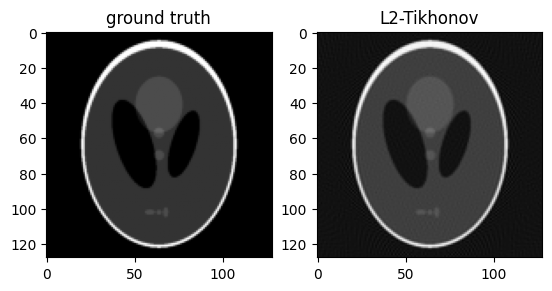

In [53]:

# x_A  = algo_A(y, physics)
x_A = model(y, physics)

print(x_A.shape)
print("X_a:",x_A)

print("gt:" ,x_gt)


plt.figure()
plt.subplot(121)
plt.imshow(x_gt.cpu()[0,0,:,:], cmap = 'gray')
plt.title("ground truth")
plt.subplot(122)
plt.imshow(x_A.cpu()[0,0,:,:], cmap = 'gray')
plt.title("L2-Tikhonov")
plt.show()

In [ ]:
# # ── 1B. Poisson-TV  (PD3O) ──────────────────────────────────────────
# from deepinv.optim.data_fidelity import PoissonLikelihood
# from deepinv.optim.prior         import TVPrior          # needs deepinv ≥0.3
# from deepinv.optim.bregman       import IdentityPotential

# prior_B = TVPrior(weight=LAMBDA_TV)
# algo_B  = optim_builder("PD3O",
#                         data_fidelity=PoissonLikelihood(gain=GAIN),
#                         prior=prior_B,
#                         max_iter=MAXITER_B,
#                         params_algo={"stepsize": 1.0})   # PD3O is robust

# x_B, _  = algo_B(y, physics)

# # ── 2. quick visual sanity check ────────────────────────────────────
# dinv.utils.plotting.plot([y, x_gt, x_A, x_B],
#         titles=["Sinogram", "Ground-truth", "Tikhonov", "Poisson-TV"],
#         save_dir="results", show=True)